In [1]:
import numpy as np

import matplotlib.pyplot as plt
import urllib.request
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import csv
import requests
import math
from scipy.signal import find_peaks
from datetime import datetime, date, timedelta
from scipy import signal


In [2]:
def get_data(year):
    """Retrieves data from Cassini's Saturn orbits for a given year."""
    #Filename
    filename = str(year) + "_FGM_KSM_1M.TAB"

    #Retrieve data from csv file in pandas dataframe
    df = pd.read_csv(filename, infer_datetime_format=True, sep='\s+', names=["Time","BX","BY","BZ","Btotal","X","Y",'Z','LocalHour','NPTS'], engine='python')
    return df
def fill_data(data): 
    """Add columns for Rs=(x**2 + y**2)**0.5 and the elevation and azimuthal angles."""
    #Set the index as the 'Time' column
    data["Time"] = pd.to_datetime(data["Time"], format='%Y/%m/%d %H:%M:%S')
    data = data.set_index("Time")

    #add columns
    y = data["Y"]
    z = data["Z"]
    data['Rs'] = ((z*z)+(y*y))**0.5
    data["Elevation"] = np.degrees(np.arctan(data["BZ"]/(data["BX"]**2 + data["BY"]**2)**0.5))
    data["Azimuth"] = np.degrees(np.arccos(-data["BX"]/(data["BX"]**2 + data["BY"]**2)**0.5))

    return data
def get_day_data(daymin, daymax, year):
    """Returns a sample of the data for a given day range and year"""
    global get_data, fill_data

    yeardata = get_data(year)
    yeardata = fill_data(yeardata)
    start_date = pd.Timestamp(datetime(int(year), 1, 1) + timedelta(daymin-1, 30))
    end_date = pd.Timestamp(datetime(int(year), 1, 1) + timedelta(daymax-1, 30))
    start_index = yeardata.index.get_loc(start_date, method="nearest")
    end_index = yeardata.index.get_loc(end_date, method="nearest")
    print("Sample start date: ",yeardata.index[start_index],"\nSample end date:",yeardata.index[end_index])
    yeardata = yeardata[start_index:end_index]

    return yeardata
def smoothdata(data,window_length,polyorder):
    """Returns a smoothed out form of the data"""

    return signal.savgol_filter(data,window_length,polyorder)

Sample start date:  2005-10-06 00:00:30 
Sample end date: 2005-10-08 00:00:30
Shape of VHM Data between Days 279 and 281 of 2005:  (2853, 12)


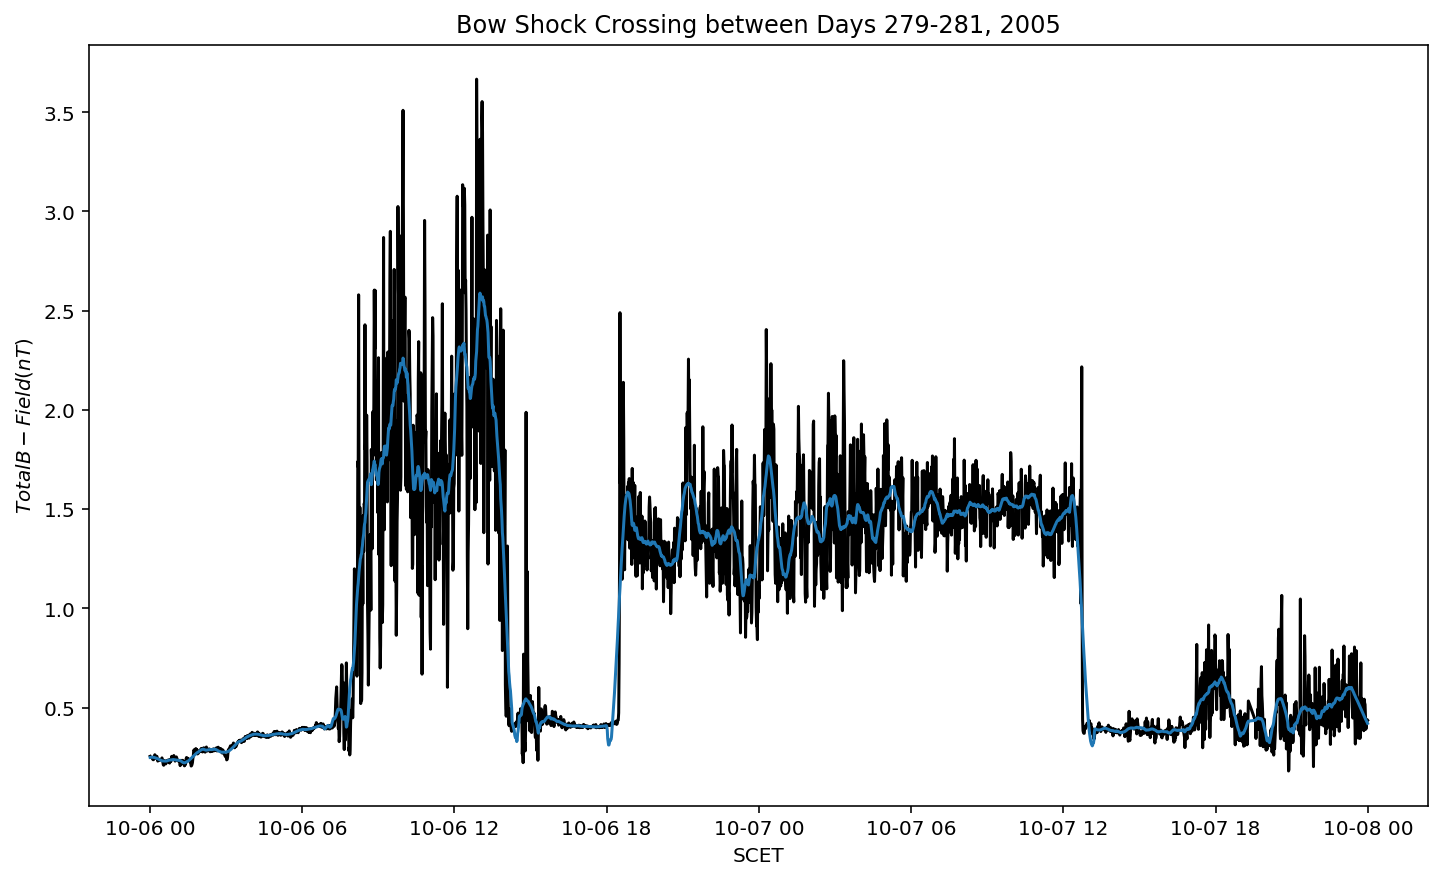

In [3]:
year = 2005
start_day = 279
end_day = 281

day_data_2005 = get_day_data(start_day, end_day, year)

print("Shape of VHM Data between Days 279 and 281 of 2005: ",np.shape(day_data_2005))
range_ = 1400 #minutes
crossing = day_data_2005["Btotal"]#[1000: 1000 + range_]
window=int(((60*(end_day-start_day))-1)/2)
plt.figure()
plt.plot(crossing, color="black")
plt.plot(crossing.index,smoothdata(crossing,window,  3))
plt.title("Bow Shock Crossing between Days %s-%s, %s"%(str(start_day), str(end_day), year))
plt.xlabel("SCET")
plt.ylabel(r'$Total B-Field \left(nT\right)$');

59
32.545114582811905
[ 581  767  880 1102 1632]
[ 539  784 2198]


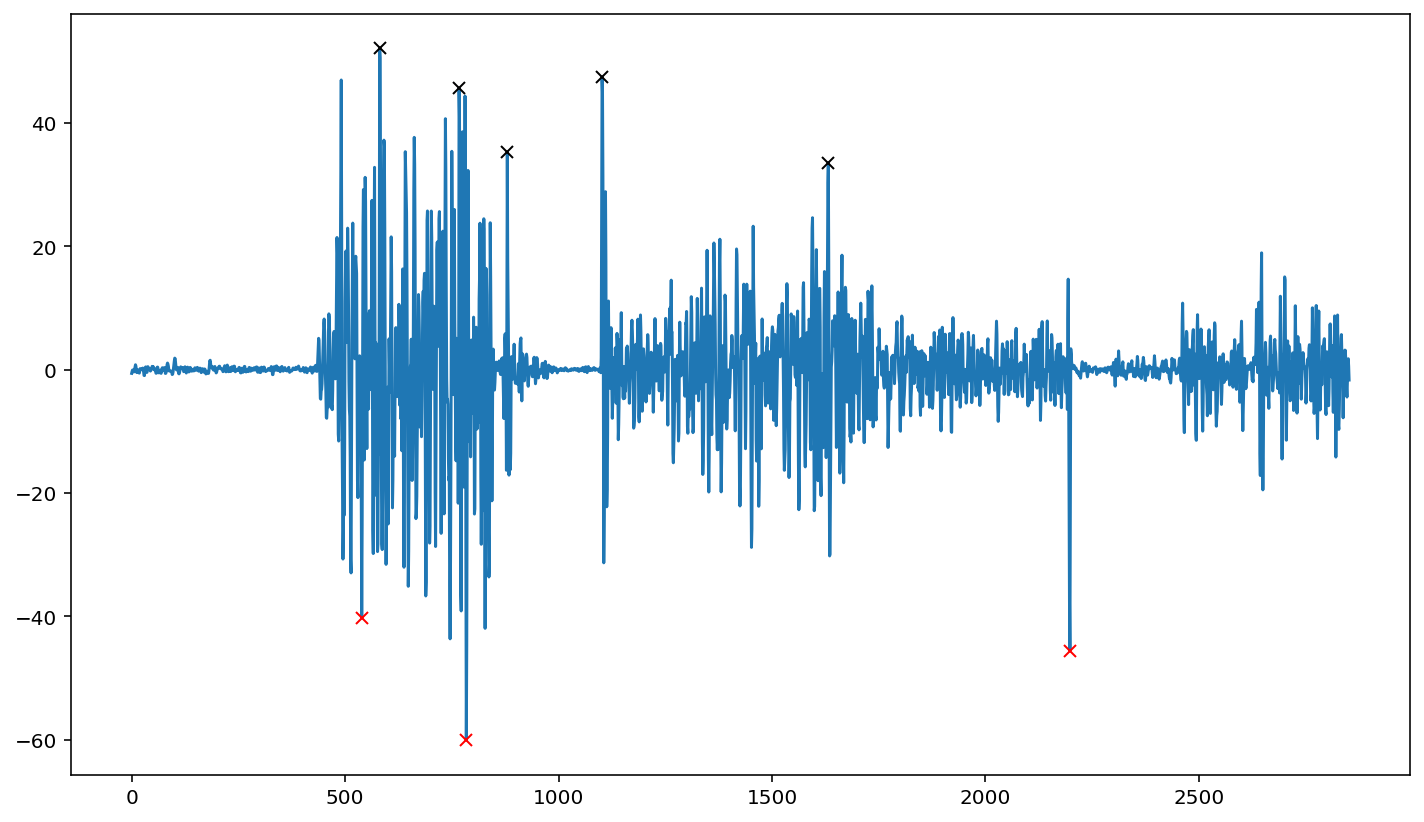

In [4]:
dif3=np.gradient(smoothdata(crossing,7,  3),0.01,edge_order=2)
#dif=np.gradient(crossing,0.05,edge_order=2)
ncross=7
h=np.quantile(dif3,1-(2*(ncross+1)/len(dif3)))-1
print(window)
print(h)
plt.figure()
#plt.plot(dif)
plt.plot(dif3)

cross,_=find_peaks(dif3,height=h,distance=100)
exit,_= find_peaks(-dif3,height=h,distance=200)
plt.plot(cross,dif3[cross],'x',c='k')
plt.plot(exit,dif3[exit],'x',c='r')
print(cross)
print(exit)

DatetimeIndex(['2005-10-06 09:44:30', '2005-10-06 12:50:30',
               '2005-10-06 14:47:30', '2005-10-06 18:29:30',
               '2005-10-07 03:19:30'],
              dtype='datetime64[ns]', name='Time', freq=None) entry Crossing times
DatetimeIndex(['2005-10-06 09:02:30', '2005-10-06 13:07:30',
               '2005-10-07 12:45:30'],
              dtype='datetime64[ns]', name='Time', freq=None) exit crossing times


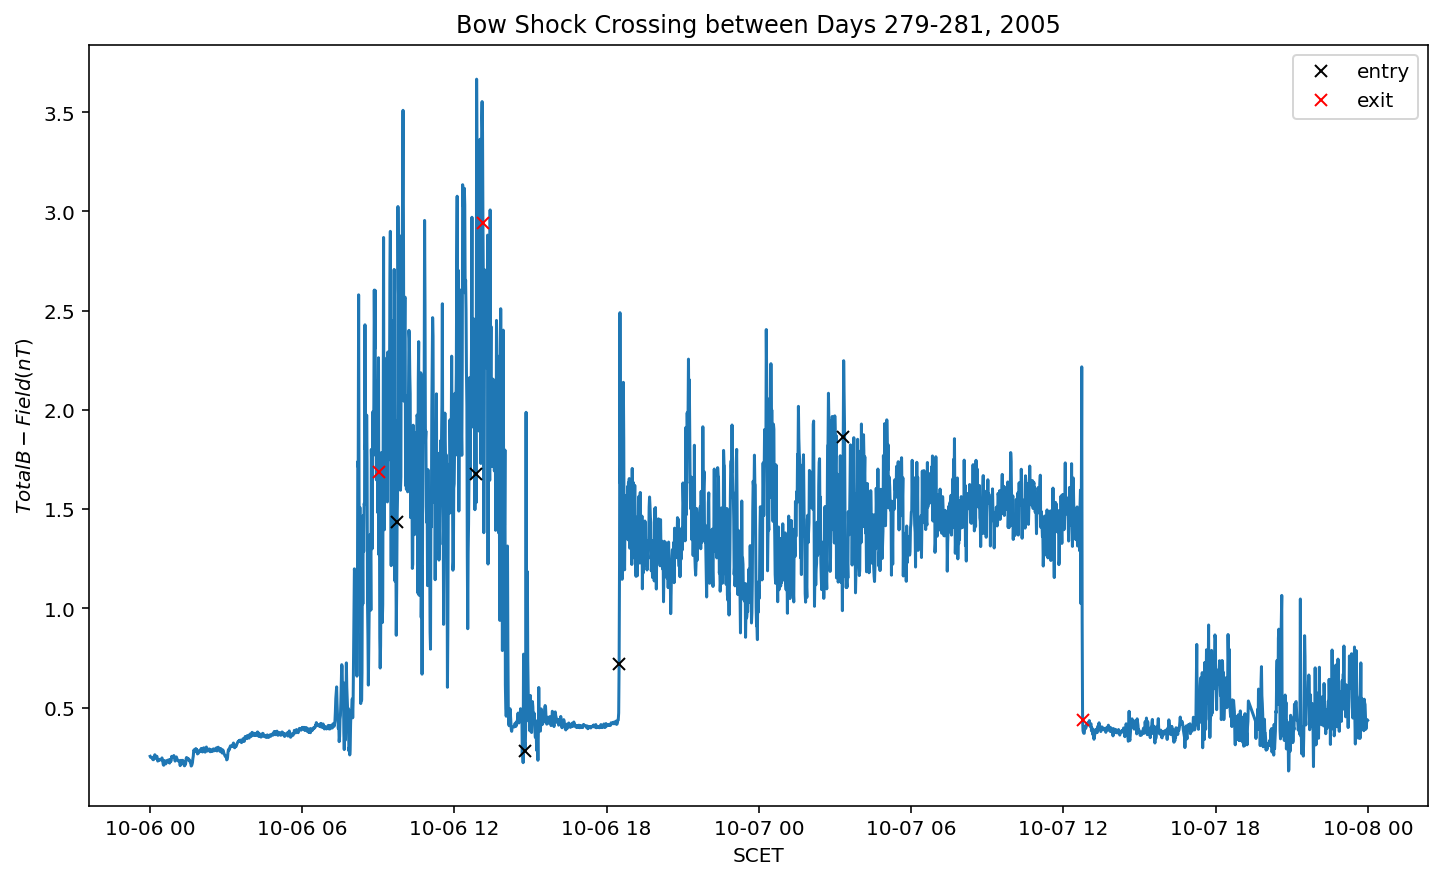

In [5]:

plt.figure()
plt.plot(crossing)
plt.title("Bow Shock Crossing between Days %s-%s, %s"%(str(start_day), str(end_day), year))
plt.xlabel("SCET")
plt.ylabel(r'$Total B-Field \left(nT\right)$');
plt.plot(crossing.index[cross],crossing[cross] ,'x',color= "k",label='entry')
plt.plot(crossing.index[exit], crossing[exit] ,'x',color= "r",label='exit')
plt.legend()
print(crossing.index[cross],'entry Crossing times')
print(crossing.index[exit],'exit crossing times')

In [6]:
%matplotlib inline


In [7]:
from ipywidgets import interactive
from IPython.display import display

In [8]:
def plot_line(ind):
    plt.figure(figsize=(15,10))
    plt.plot(crossing,c='k')
    plt.axvline(crossing.index[ind], color= "red")

line = interactive(plot_line, ind=(0,len(crossing),1))
display(line)

interactive(children=(IntSlider(value=1426, description='ind', max=2853), Output()), _dom_classes=('widget-int…

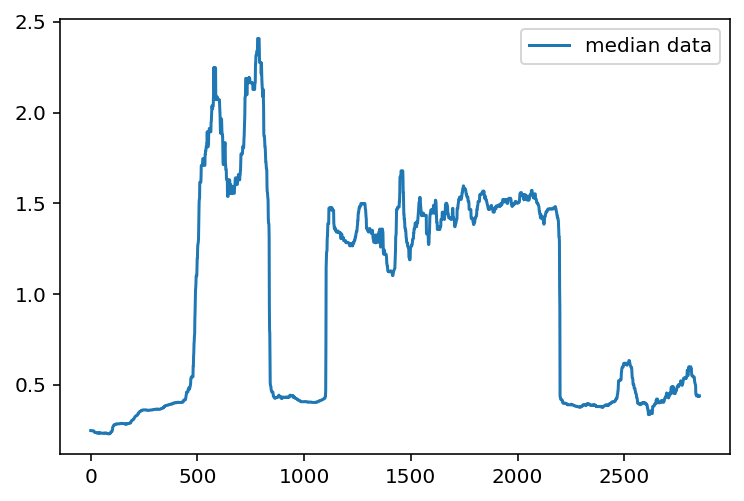

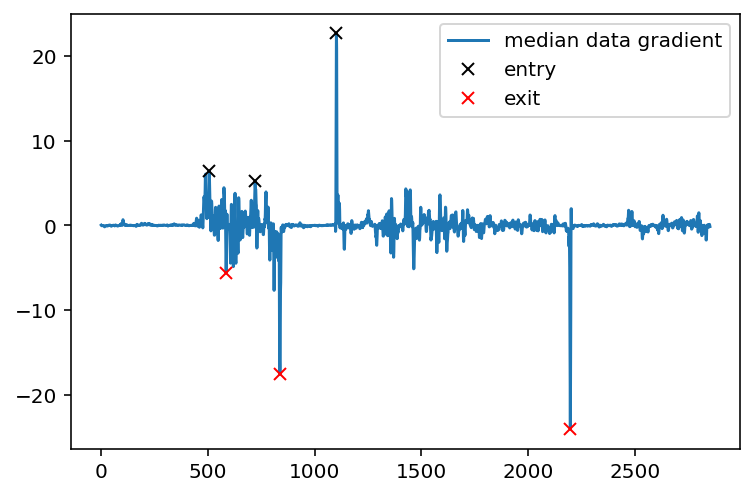

In [12]:
from scipy import ndimage
y=ndimage.median_filter(crossing, size=40)
plt.figure()
plt.plot(y,label='median data')
plt.legend()
ydiff=np.gradient(smoothdata(y,7,  3),0.01,edge_order=2)
plt.figure()
plt.plot(ydiff,label='median data gradient')
ncross=4.6
hy=np.quantile(ydiff,1-(2*(ncross)/len(ydiff)))
ycross,_=find_peaks(ydiff,height=hy,distance=200)
yexit,_= find_peaks(-ydiff,height=hy,distance=200)
plt.plot(ycross,ydiff[ycross],'x',c='k',label='entry')
plt.plot(yexit,ydiff[yexit],'x',c='r',label='exit')
plt.legend()

DatetimeIndex(['2005-10-06 08:26:30', '2005-10-06 12:04:30',
               '2005-10-06 18:29:30'],
              dtype='datetime64[ns]', name='Time', freq=None) entry Crossing times
DatetimeIndex(['2005-10-06 09:48:30', '2005-10-06 14:00:30',
               '2005-10-07 12:45:30'],
              dtype='datetime64[ns]', name='Time', freq=None) exit crossing times


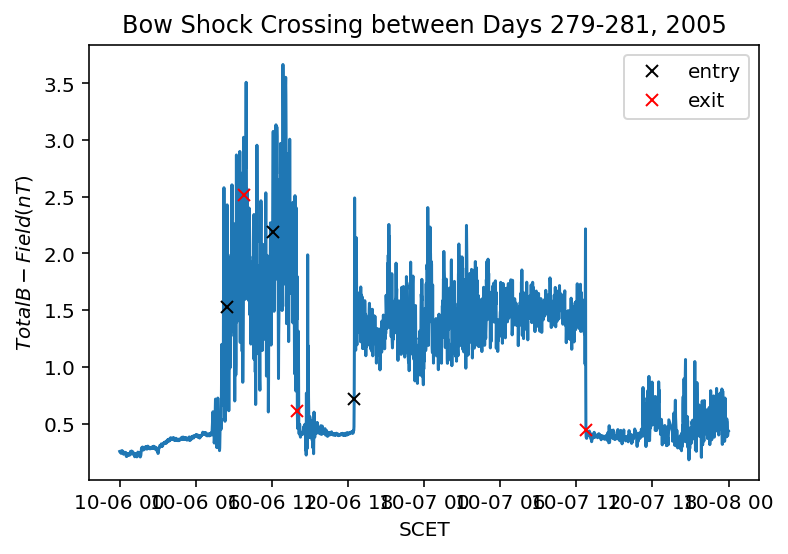

In [10]:

plt.figure()
plt.plot(crossing)
plt.title("Bow Shock Crossing between Days %s-%s, %s"%(str(start_day), str(end_day), year))
plt.xlabel("SCET")
plt.ylabel(r'$Total B-Field \left(nT\right)$');
plt.plot(crossing.index[ycross],crossing[ycross] ,'x',color= "k",label='entry')
plt.plot(crossing.index[yexit], crossing[yexit] ,'x',color= "r",label='exit')
plt.legend()
print(crossing.index[ycross],'entry Crossing times')
print(crossing.index[yexit],'exit crossing times')

In [11]:
from Functions import *